# Low-Dimensional Representation Using Autoencoder

## Getting the Data

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [2]:
import urllib
file_url = 'https://datasync.ed.ac.uk/public.php/webdav'

password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()
password_mgr.add_password(None, file_url, "GbnXJ5bU3m9JPau", "HS2")
handler = urllib.request.HTTPBasicAuthHandler(password_mgr)
opener = urllib.request.build_opener(handler)
opener.open(file_url)
urllib.request.install_opener(opener)
with urllib.request.urlopen(file_url) as response, open('visapy_data.npy', 'wb') as out_file:
    data = response.read()
    out_file.write(data)

# raw data location
data_path = 'visapy_data.npy'

In [3]:
# detection parameters
to_localize = False
cutout_start = 14
cutout_end = 36
threshold = 24
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [4]:
Probe = HierlmannVisapyEmulationProbe('visapy_data.npy')
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


## Detecting Spikes

In [5]:
H.DetectFromRaw()

# Sampling rate: 32000
# Localization Off
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 75

In [6]:
H.LoadDetected()

Detected and read 19341 spikes.


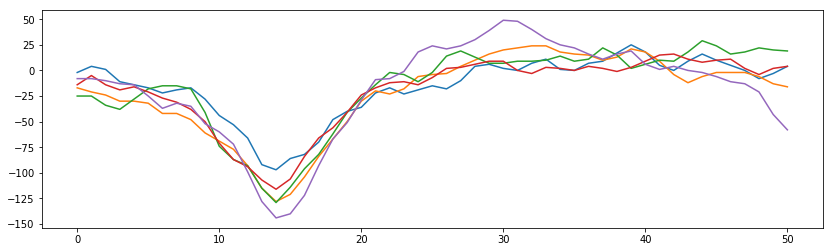

In [85]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,4))
for i in [14, 18, 77, 90, 156]:
    plt.plot(H.spikes['Shape'][i])
plt.show()
    

In [8]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]
embedding_size = (int)(length//4)

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(19341, 51)


## Scaling data between 0 and 1

In [9]:
# electrode_data = electrode_data_temp[:, :]

In [10]:
# max_val = np.amax(electrode_data)
# min_val = np.amin(electrode_data)
# span = max_val - min_val
# electrode_data = (electrode_data - min_val)/span

In [11]:
print(electrode_data)

[[ -7.  -2.   4. ...   7.   7.   9.]
 [ 35.  33.  26. ...   0.  -7. -10.]
 [ 15.  16.   8. ... -11.  -1.   1.]
 ...
 [ -2. -19. -23. ...  -7. -15. -31.]
 [ 12.   0.  -3. ...  -8. -10.  -5.]
 [-20. -32. -29. ...   9.   0.  -9.]]


## Designing the AutoEncoder 

In [12]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(0)
torch.manual_seed(0)

In [13]:
class autoencoder(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, 28),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 16),
                                     activation_layer,
                                     nn.Linear(16, 25),
                                     activation_layer,
                                     nn.Linear(25, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

## Splitting the data into Train and Test

In [14]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (15472, 51)
Test Datasize: (3869, 51)


In [15]:
random.seed(0)

def train_ae(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        for feats in selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = model.forward(x)
            out = torch.tensor(out).float().cuda()
            loss = criterion(out, x)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.data[0])
        print('epoch [{}/{}], loss:{:.5f}, avg:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], sum(losses[-10:])/len(losses[-10:])))
    return enc, out, losses

In [16]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

In [17]:
epoch_range = 5000
batch_size = 150
learning_rate = 0.0001

ae_1 = autoencoder(length, embedding_size).cuda()
ae_1.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_1.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses = train_ae(ae_1, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/5000], loss:2696.60938, avg:2696.60938
epoch [2/5000], loss:814.14386, avg:1755.37659
epoch [3/5000], loss:359.83264, avg:1290.19531
epoch [4/5000], loss:91.81929, avg:990.60132
epoch [5/5000], loss:119.90456, avg:816.46198
epoch [6/5000], loss:70.90757, avg:692.20288
epoch [7/5000], loss:376.38910, avg:647.08667
epoch [8/5000], loss:156.40436, avg:585.75134
epoch [9/5000], loss:302.80026, avg:554.31232
epoch [10/5000], loss:583.59979, avg:557.24109
epoch [11/5000], loss:55.95045, avg:293.17520
epoch [12/5000], loss:181.54216, avg:229.91504
epoch [13/5000], loss:73.21373, avg:201.25313
epoch [14/5000], loss:47.89215, avg:196.86040
epoch [15/5000], loss:373.94431, avg:222.26439
epoch [16/5000], loss:247.13025, avg:239.88667
epoch [17/5000], loss:89.82492, avg:211.23022
epoch [18/5000], loss:351.12759, avg:230.70256
epoch [19/5000], loss:69.86075, avg:207.40862
epoch [20/5000], loss:81.79202, avg:157.22783
epoch [21/5000], loss:335.43103, avg:185.17589
epoch [22/5000], loss:49.9

epoch [180/5000], loss:30.37217, avg:40.77320
epoch [181/5000], loss:27.64705, avg:41.26963
epoch [182/5000], loss:51.22570, avg:41.50315
epoch [183/5000], loss:54.36275, avg:42.64886
epoch [184/5000], loss:35.15639, avg:40.00033
epoch [185/5000], loss:70.78148, avg:43.49968
epoch [186/5000], loss:155.31964, avg:55.47728
epoch [187/5000], loss:48.24220, avg:56.88478
epoch [188/5000], loss:33.99423, avg:54.18436
epoch [189/5000], loss:60.94137, avg:56.80430
epoch [190/5000], loss:37.26187, avg:57.49327
epoch [191/5000], loss:70.54962, avg:61.78353
epoch [192/5000], loss:38.03685, avg:60.46465
epoch [193/5000], loss:53.05456, avg:60.33383
epoch [194/5000], loss:30.18585, avg:59.83677
epoch [195/5000], loss:48.61544, avg:57.62016
epoch [196/5000], loss:45.59544, avg:46.64775
epoch [197/5000], loss:82.78248, avg:50.10177
epoch [198/5000], loss:53.47141, avg:52.04949
epoch [199/5000], loss:62.21800, avg:52.17715
epoch [200/5000], loss:75.98025, avg:56.04899
epoch [201/5000], loss:53.25534, 

epoch [359/5000], loss:43.50528, avg:34.06677
epoch [360/5000], loss:27.40664, avg:34.43447
epoch [361/5000], loss:31.90886, avg:35.14094
epoch [362/5000], loss:34.23763, avg:35.34898
epoch [363/5000], loss:26.34055, avg:34.17495
epoch [364/5000], loss:28.82308, avg:31.15774
epoch [365/5000], loss:34.24591, avg:31.92059
epoch [366/5000], loss:44.48229, avg:32.50608
epoch [367/5000], loss:85.20782, avg:38.65677
epoch [368/5000], loss:22.27472, avg:37.84328
epoch [369/5000], loss:49.39753, avg:38.43250
epoch [370/5000], loss:21.99598, avg:37.89143
epoch [371/5000], loss:21.69054, avg:36.86960
epoch [372/5000], loss:42.21710, avg:37.66755
epoch [373/5000], loss:25.42008, avg:37.57550
epoch [374/5000], loss:39.23081, avg:38.61628
epoch [375/5000], loss:48.33466, avg:40.02515
epoch [376/5000], loss:39.52853, avg:39.52978
epoch [377/5000], loss:39.37114, avg:34.94611
epoch [378/5000], loss:74.69743, avg:40.18838
epoch [379/5000], loss:50.08171, avg:40.25680
epoch [380/5000], loss:27.32032, a

epoch [538/5000], loss:30.51283, avg:34.61929
epoch [539/5000], loss:26.73801, avg:34.57855
epoch [540/5000], loss:40.52413, avg:34.67517
epoch [541/5000], loss:52.94738, avg:36.18084
epoch [542/5000], loss:51.31412, avg:38.98721
epoch [543/5000], loss:58.75481, avg:42.73457
epoch [544/5000], loss:37.47222, avg:39.20555
epoch [545/5000], loss:31.81076, avg:39.19935
epoch [546/5000], loss:29.49980, avg:40.29004
epoch [547/5000], loss:31.72086, avg:39.12949
epoch [548/5000], loss:52.02752, avg:41.28096
epoch [549/5000], loss:43.37822, avg:42.94498
epoch [550/5000], loss:62.95803, avg:45.18837
epoch [551/5000], loss:53.16006, avg:45.20964
epoch [552/5000], loss:90.83398, avg:49.16163
epoch [553/5000], loss:35.84064, avg:46.87021
epoch [554/5000], loss:52.29148, avg:48.35213
epoch [555/5000], loss:40.01760, avg:49.17282
epoch [556/5000], loss:43.78710, avg:50.60155
epoch [557/5000], loss:49.85608, avg:52.41508
epoch [558/5000], loss:41.09628, avg:51.32195
epoch [559/5000], loss:87.17284, a

epoch [717/5000], loss:23.71117, avg:43.55882
epoch [718/5000], loss:26.24952, avg:42.48815
epoch [719/5000], loss:19.29515, avg:36.54552
epoch [720/5000], loss:15.49203, avg:34.19830
epoch [721/5000], loss:32.41243, avg:35.04182
epoch [722/5000], loss:25.19002, avg:33.93089
epoch [723/5000], loss:41.96333, avg:30.07471
epoch [724/5000], loss:41.23629, avg:29.09312
epoch [725/5000], loss:20.15888, avg:28.23500
epoch [726/5000], loss:30.85926, avg:27.65681
epoch [727/5000], loss:33.72813, avg:28.65850
epoch [728/5000], loss:39.81716, avg:30.01526
epoch [729/5000], loss:53.39326, avg:33.42508
epoch [730/5000], loss:37.87633, avg:35.66351
epoch [731/5000], loss:27.61314, avg:35.18358
epoch [732/5000], loss:45.77225, avg:37.24181
epoch [733/5000], loss:17.70071, avg:34.81554
epoch [734/5000], loss:31.46008, avg:33.83792
epoch [735/5000], loss:33.52443, avg:35.17448
epoch [736/5000], loss:38.56190, avg:35.94474
epoch [737/5000], loss:46.84148, avg:37.25607
epoch [738/5000], loss:11.25904, a

epoch [896/5000], loss:24.73779, avg:35.86804
epoch [897/5000], loss:17.48289, avg:33.37187
epoch [898/5000], loss:28.23438, avg:32.81414
epoch [899/5000], loss:23.68900, avg:32.14965
epoch [900/5000], loss:25.54395, avg:27.24740
epoch [901/5000], loss:92.27337, avg:33.03403
epoch [902/5000], loss:65.49770, avg:36.63318
epoch [903/5000], loss:35.75303, avg:36.49041
epoch [904/5000], loss:24.19227, avg:36.68573
epoch [905/5000], loss:28.90088, avg:36.63052
epoch [906/5000], loss:42.67758, avg:38.42450
epoch [907/5000], loss:21.76142, avg:38.85236
epoch [908/5000], loss:26.73048, avg:38.70197
epoch [909/5000], loss:14.92080, avg:37.82515
epoch [910/5000], loss:21.72572, avg:37.44332
epoch [911/5000], loss:34.13742, avg:31.62973
epoch [912/5000], loss:44.90856, avg:29.57082
epoch [913/5000], loss:27.44491, avg:28.74001
epoch [914/5000], loss:23.62370, avg:28.68315
epoch [915/5000], loss:16.49580, avg:27.44264
epoch [916/5000], loss:24.22811, avg:25.59769
epoch [917/5000], loss:28.19476, a

epoch [1073/5000], loss:34.04404, avg:30.29893
epoch [1074/5000], loss:22.89112, avg:29.89446
epoch [1075/5000], loss:21.43484, avg:27.13073
epoch [1076/5000], loss:33.16687, avg:28.66400
epoch [1077/5000], loss:14.92682, avg:28.03301
epoch [1078/5000], loss:23.01168, avg:27.14876
epoch [1079/5000], loss:42.04086, avg:28.71655
epoch [1080/5000], loss:46.44767, avg:29.92063
epoch [1081/5000], loss:21.26286, avg:28.66506
epoch [1082/5000], loss:33.48499, avg:29.27117
epoch [1083/5000], loss:27.30956, avg:28.59773
epoch [1084/5000], loss:25.14476, avg:28.82309
epoch [1085/5000], loss:28.22096, avg:29.50170
epoch [1086/5000], loss:40.02540, avg:30.18756
epoch [1087/5000], loss:60.14120, avg:34.70900
epoch [1088/5000], loss:15.23143, avg:33.93097
epoch [1089/5000], loss:50.09723, avg:34.73661
epoch [1090/5000], loss:45.82018, avg:34.67386
epoch [1091/5000], loss:23.70895, avg:34.91847
epoch [1092/5000], loss:34.54899, avg:35.02487
epoch [1093/5000], loss:32.27000, avg:35.52091
epoch [1094/5

epoch [1248/5000], loss:15.03532, avg:32.48872
epoch [1249/5000], loss:16.73348, avg:29.83955
epoch [1250/5000], loss:41.35163, avg:30.87362
epoch [1251/5000], loss:23.37390, avg:30.32521
epoch [1252/5000], loss:32.76156, avg:30.48725
epoch [1253/5000], loss:51.33578, avg:32.43793
epoch [1254/5000], loss:29.33348, avg:31.70758
epoch [1255/5000], loss:38.56460, avg:32.58484
epoch [1256/5000], loss:67.94086, avg:34.35675
epoch [1257/5000], loss:35.33389, avg:35.17645
epoch [1258/5000], loss:23.19590, avg:35.99251
epoch [1259/5000], loss:30.36397, avg:37.35556
epoch [1260/5000], loss:22.74518, avg:35.49492
epoch [1261/5000], loss:43.32529, avg:37.49005
epoch [1262/5000], loss:16.75250, avg:35.88914
epoch [1263/5000], loss:45.06017, avg:35.26159
epoch [1264/5000], loss:42.42332, avg:36.57057
epoch [1265/5000], loss:16.42402, avg:34.35651
epoch [1266/5000], loss:39.42363, avg:31.50479
epoch [1267/5000], loss:30.52114, avg:31.02351
epoch [1268/5000], loss:37.67413, avg:32.47134
epoch [1269/5

epoch [1423/5000], loss:41.22040, avg:27.58342
epoch [1424/5000], loss:28.84665, avg:28.48828
epoch [1425/5000], loss:17.25550, avg:27.98001
epoch [1426/5000], loss:32.53134, avg:27.74423
epoch [1427/5000], loss:20.61199, avg:26.16085
epoch [1428/5000], loss:32.81709, avg:27.85628
epoch [1429/5000], loss:16.47674, avg:26.04023
epoch [1430/5000], loss:45.00499, avg:28.34125
epoch [1431/5000], loss:28.74983, avg:29.20745
epoch [1432/5000], loss:24.95107, avg:28.84656
epoch [1433/5000], loss:37.07498, avg:28.43202
epoch [1434/5000], loss:31.94788, avg:28.74214
epoch [1435/5000], loss:40.91245, avg:31.10784
epoch [1436/5000], loss:34.76968, avg:31.33167
epoch [1437/5000], loss:34.00145, avg:32.67062
epoch [1438/5000], loss:21.69471, avg:31.55838
epoch [1439/5000], loss:19.47620, avg:31.85833
epoch [1440/5000], loss:20.38846, avg:29.39667
epoch [1441/5000], loss:43.71347, avg:30.89304
epoch [1442/5000], loss:22.33370, avg:30.63130
epoch [1443/5000], loss:17.59336, avg:28.68314
epoch [1444/5

epoch [1598/5000], loss:34.28534, avg:29.17055
epoch [1599/5000], loss:12.16077, avg:27.42404
epoch [1600/5000], loss:19.49515, avg:28.00154
epoch [1601/5000], loss:22.26471, avg:27.06685
epoch [1602/5000], loss:28.80965, avg:26.59806
epoch [1603/5000], loss:20.21273, avg:26.07133
epoch [1604/5000], loss:31.44010, avg:25.35800
epoch [1605/5000], loss:33.02784, avg:26.02972
epoch [1606/5000], loss:26.52491, avg:25.00688
epoch [1607/5000], loss:26.80161, avg:25.50228
epoch [1608/5000], loss:37.30380, avg:25.80413
epoch [1609/5000], loss:30.80712, avg:27.66876
epoch [1610/5000], loss:27.99228, avg:28.51848
epoch [1611/5000], loss:19.79666, avg:28.27167
epoch [1612/5000], loss:50.54835, avg:30.44554
epoch [1613/5000], loss:30.66412, avg:31.49068
epoch [1614/5000], loss:30.02672, avg:31.34934
epoch [1615/5000], loss:12.91522, avg:29.33808
epoch [1616/5000], loss:23.96133, avg:29.08172
epoch [1617/5000], loss:26.27673, avg:29.02923
epoch [1618/5000], loss:17.82466, avg:27.08132
epoch [1619/5

epoch [1773/5000], loss:33.93323, avg:29.37738
epoch [1774/5000], loss:42.39423, avg:30.82439
epoch [1775/5000], loss:36.28306, avg:31.72401
epoch [1776/5000], loss:49.15773, avg:34.24795
epoch [1777/5000], loss:27.22382, avg:35.52371
epoch [1778/5000], loss:37.80507, avg:37.15533
epoch [1779/5000], loss:18.88213, avg:36.07689
epoch [1780/5000], loss:22.77833, avg:34.82486
epoch [1781/5000], loss:16.80252, avg:32.58641
epoch [1782/5000], loss:27.51829, avg:31.27784
epoch [1783/5000], loss:19.09513, avg:29.79403
epoch [1784/5000], loss:37.70903, avg:29.32551
epoch [1785/5000], loss:23.21366, avg:28.01857
epoch [1786/5000], loss:36.00201, avg:26.70300
epoch [1787/5000], loss:11.69510, avg:25.15013
epoch [1788/5000], loss:34.00916, avg:24.77054
epoch [1789/5000], loss:30.19467, avg:25.90179
epoch [1790/5000], loss:17.95092, avg:25.41905
epoch [1791/5000], loss:27.39047, avg:26.47784
epoch [1792/5000], loss:17.76762, avg:25.50278
epoch [1793/5000], loss:29.12120, avg:26.50539
epoch [1794/5

epoch [1948/5000], loss:46.04365, avg:32.06545
epoch [1949/5000], loss:32.17924, avg:33.51648
epoch [1950/5000], loss:17.46436, avg:31.78934
epoch [1951/5000], loss:50.93495, avg:32.06817
epoch [1952/5000], loss:18.44420, avg:30.65202
epoch [1953/5000], loss:17.22118, avg:27.50384
epoch [1954/5000], loss:36.94335, avg:27.56510
epoch [1955/5000], loss:33.42332, avg:28.81599
epoch [1956/5000], loss:33.18129, avg:30.53369
epoch [1957/5000], loss:28.97509, avg:31.48106
epoch [1958/5000], loss:32.31588, avg:30.10829
epoch [1959/5000], loss:12.29523, avg:28.11989
epoch [1960/5000], loss:33.79871, avg:29.75332
epoch [1961/5000], loss:26.89341, avg:27.34917
epoch [1962/5000], loss:27.18572, avg:28.22332
epoch [1963/5000], loss:28.43343, avg:29.34454
epoch [1964/5000], loss:44.75757, avg:30.12597
epoch [1965/5000], loss:23.05472, avg:29.08911
epoch [1966/5000], loss:17.79301, avg:27.55028
epoch [1967/5000], loss:19.70510, avg:26.62328
epoch [1968/5000], loss:42.23475, avg:27.61517
epoch [1969/5

epoch [2123/5000], loss:23.81826, avg:27.81418
epoch [2124/5000], loss:26.47634, avg:27.42231
epoch [2125/5000], loss:37.15443, avg:27.58703
epoch [2126/5000], loss:34.85284, avg:29.01906
epoch [2127/5000], loss:36.48051, avg:31.02007
epoch [2128/5000], loss:22.53092, avg:31.92120
epoch [2129/5000], loss:16.95826, avg:30.91747
epoch [2130/5000], loss:41.76183, avg:30.63698
epoch [2131/5000], loss:54.05700, avg:32.69235
epoch [2132/5000], loss:21.78428, avg:31.58747
epoch [2133/5000], loss:29.44843, avg:32.15049
epoch [2134/5000], loss:30.19733, avg:32.52259
epoch [2135/5000], loss:30.36304, avg:31.84344
epoch [2136/5000], loss:24.56334, avg:30.81450
epoch [2137/5000], loss:25.67111, avg:29.73355
epoch [2138/5000], loss:18.03307, avg:29.28377
epoch [2139/5000], loss:30.71389, avg:30.65934
epoch [2140/5000], loss:30.00300, avg:29.48345
epoch [2141/5000], loss:30.70698, avg:27.14845
epoch [2142/5000], loss:27.97906, avg:27.76793
epoch [2143/5000], loss:17.16709, avg:26.53979
epoch [2144/5

epoch [2298/5000], loss:32.82001, avg:33.20343
epoch [2299/5000], loss:20.39518, avg:30.49275
epoch [2300/5000], loss:32.73787, avg:31.09372
epoch [2301/5000], loss:14.24481, avg:27.12268
epoch [2302/5000], loss:34.38744, avg:28.17000
epoch [2303/5000], loss:25.78099, avg:28.78683
epoch [2304/5000], loss:17.75713, avg:27.37542
epoch [2305/5000], loss:22.05369, avg:24.55643
epoch [2306/5000], loss:24.91148, avg:25.72493
epoch [2307/5000], loss:42.25215, avg:26.73407
epoch [2308/5000], loss:20.95732, avg:25.54781
epoch [2309/5000], loss:27.95726, avg:26.30401
epoch [2310/5000], loss:21.20569, avg:25.15079
epoch [2311/5000], loss:27.22424, avg:26.44874
epoch [2312/5000], loss:30.00179, avg:26.01018
epoch [2313/5000], loss:23.57813, avg:25.78989
epoch [2314/5000], loss:22.88749, avg:26.30292
epoch [2315/5000], loss:24.83567, avg:26.58112
epoch [2316/5000], loss:36.12550, avg:27.70252
epoch [2317/5000], loss:24.12645, avg:25.88995
epoch [2318/5000], loss:31.20734, avg:26.91495
epoch [2319/5

epoch [2473/5000], loss:11.47659, avg:23.99258
epoch [2474/5000], loss:21.82142, avg:23.77104
epoch [2475/5000], loss:62.83067, avg:27.52042
epoch [2476/5000], loss:23.04547, avg:28.49145
epoch [2477/5000], loss:15.89276, avg:28.19025
epoch [2478/5000], loss:41.37010, avg:29.88833
epoch [2479/5000], loss:30.83478, avg:30.62567
epoch [2480/5000], loss:50.20326, avg:32.48981
epoch [2481/5000], loss:18.03590, avg:31.33643
epoch [2482/5000], loss:23.40303, avg:29.89140
epoch [2483/5000], loss:57.80422, avg:34.52417
epoch [2484/5000], loss:23.83449, avg:34.72548
epoch [2485/5000], loss:33.09394, avg:31.75180
epoch [2486/5000], loss:21.63215, avg:31.61046
epoch [2487/5000], loss:26.72369, avg:32.69355
epoch [2488/5000], loss:61.46575, avg:34.70312
epoch [2489/5000], loss:37.92337, avg:35.41198
epoch [2490/5000], loss:28.64829, avg:33.25648
epoch [2491/5000], loss:26.08474, avg:34.06137
epoch [2492/5000], loss:27.72355, avg:34.49342
epoch [2493/5000], loss:51.90298, avg:33.90330
epoch [2494/5

epoch [2648/5000], loss:26.07262, avg:29.20367
epoch [2649/5000], loss:21.30103, avg:29.54109
epoch [2650/5000], loss:22.83262, avg:28.49467
epoch [2651/5000], loss:24.10092, avg:26.95512
epoch [2652/5000], loss:36.23259, avg:27.48083
epoch [2653/5000], loss:20.51370, avg:25.40252
epoch [2654/5000], loss:25.00671, avg:25.22345
epoch [2655/5000], loss:16.94155, avg:23.37901
epoch [2656/5000], loss:18.42040, avg:22.78078
epoch [2657/5000], loss:31.88528, avg:24.33074
epoch [2658/5000], loss:25.57183, avg:24.28066
epoch [2659/5000], loss:26.25312, avg:24.77587
epoch [2660/5000], loss:30.07259, avg:25.49987
epoch [2661/5000], loss:32.25156, avg:26.31493
epoch [2662/5000], loss:42.91878, avg:26.98355
epoch [2663/5000], loss:33.60684, avg:28.29287
epoch [2664/5000], loss:25.05869, avg:28.29806
epoch [2665/5000], loss:28.05846, avg:29.40976
epoch [2666/5000], loss:19.86240, avg:29.55396
epoch [2667/5000], loss:17.99690, avg:28.16512
epoch [2668/5000], loss:29.03214, avg:28.51114
epoch [2669/5

epoch [2823/5000], loss:31.71870, avg:27.91248
epoch [2824/5000], loss:35.74422, avg:29.16924
epoch [2825/5000], loss:25.48416, avg:29.15576
epoch [2826/5000], loss:35.20234, avg:29.01908
epoch [2827/5000], loss:34.50058, avg:29.58373
epoch [2828/5000], loss:23.58733, avg:28.03800
epoch [2829/5000], loss:24.75839, avg:28.41463
epoch [2830/5000], loss:33.61030, avg:29.47656
epoch [2831/5000], loss:22.74386, avg:28.91222
epoch [2832/5000], loss:24.37996, avg:29.17298
epoch [2833/5000], loss:26.18526, avg:28.61964
epoch [2834/5000], loss:20.85389, avg:27.13061
epoch [2835/5000], loss:20.11937, avg:26.59413
epoch [2836/5000], loss:15.75909, avg:24.64980
epoch [2837/5000], loss:23.39230, avg:23.53898
epoch [2838/5000], loss:30.39164, avg:24.21941
epoch [2839/5000], loss:27.00498, avg:24.44407
epoch [2840/5000], loss:31.06378, avg:24.18941
epoch [2841/5000], loss:12.19381, avg:23.13441
epoch [2842/5000], loss:30.16406, avg:23.71282
epoch [2843/5000], loss:18.63772, avg:22.95807
epoch [2844/5

epoch [2998/5000], loss:52.78511, avg:27.27711
epoch [2999/5000], loss:31.35291, avg:27.72074
epoch [3000/5000], loss:28.13113, avg:28.13880
epoch [3001/5000], loss:30.31684, avg:28.05331
epoch [3002/5000], loss:50.67000, avg:32.12739
epoch [3003/5000], loss:16.79620, avg:31.65710
epoch [3004/5000], loss:34.61917, avg:32.11758
epoch [3005/5000], loss:26.18022, avg:32.92662
epoch [3006/5000], loss:23.06223, avg:31.38098
epoch [3007/5000], loss:35.08039, avg:32.89942
epoch [3008/5000], loss:31.60851, avg:30.78176
epoch [3009/5000], loss:12.72956, avg:28.91942
epoch [3010/5000], loss:19.42241, avg:28.04855
epoch [3011/5000], loss:31.83444, avg:28.20032
epoch [3012/5000], loss:20.75668, avg:25.20898
epoch [3013/5000], loss:24.70835, avg:26.00020
epoch [3014/5000], loss:18.51735, avg:24.39001
epoch [3015/5000], loss:35.83508, avg:25.35550
epoch [3016/5000], loss:21.79412, avg:25.22869
epoch [3017/5000], loss:35.01094, avg:25.22175
epoch [3018/5000], loss:22.04816, avg:24.26571
epoch [3019/5

epoch [3173/5000], loss:48.69018, avg:36.69268
epoch [3174/5000], loss:24.02128, avg:36.52015
epoch [3175/5000], loss:40.10543, avg:36.21405
epoch [3176/5000], loss:34.01828, avg:37.18334
epoch [3177/5000], loss:37.18340, avg:37.34181
epoch [3178/5000], loss:17.76295, avg:33.91933
epoch [3179/5000], loss:19.57637, avg:34.21869
epoch [3180/5000], loss:20.46908, avg:31.31420
epoch [3181/5000], loss:28.75021, avg:30.47904
epoch [3182/5000], loss:40.66968, avg:31.12469
epoch [3183/5000], loss:43.50181, avg:30.60585
epoch [3184/5000], loss:19.53127, avg:30.15685
epoch [3185/5000], loss:46.43401, avg:30.78971
epoch [3186/5000], loss:30.05657, avg:30.39354
epoch [3187/5000], loss:28.29562, avg:29.50476
epoch [3188/5000], loss:25.69178, avg:30.29764
epoch [3189/5000], loss:16.14172, avg:29.95418
epoch [3190/5000], loss:18.94165, avg:29.80143
epoch [3191/5000], loss:14.05937, avg:28.33235
epoch [3192/5000], loss:29.95913, avg:27.26129
epoch [3193/5000], loss:16.19530, avg:24.53064
epoch [3194/5

epoch [3348/5000], loss:22.48711, avg:27.82369
epoch [3349/5000], loss:24.78914, avg:26.95966
epoch [3350/5000], loss:53.77917, avg:29.99044
epoch [3351/5000], loss:15.44114, avg:29.45066
epoch [3352/5000], loss:35.67971, avg:30.48138
epoch [3353/5000], loss:16.43265, avg:28.60957
epoch [3354/5000], loss:29.36536, avg:28.88231
epoch [3355/5000], loss:13.29482, avg:27.31139
epoch [3356/5000], loss:11.32899, avg:25.34266
epoch [3357/5000], loss:30.52198, avg:25.31201
epoch [3358/5000], loss:13.99597, avg:24.46289
epoch [3359/5000], loss:17.32836, avg:23.71681
epoch [3360/5000], loss:37.85864, avg:22.12476
epoch [3361/5000], loss:33.61798, avg:23.94244
epoch [3362/5000], loss:26.78246, avg:23.05272
epoch [3363/5000], loss:29.34381, avg:24.34384
epoch [3364/5000], loss:19.85655, avg:23.39296
epoch [3365/5000], loss:14.18674, avg:23.48215
epoch [3366/5000], loss:25.94977, avg:24.94423
epoch [3367/5000], loss:30.83904, avg:24.97593
epoch [3368/5000], loss:48.23738, avg:28.40007
epoch [3369/5

epoch [3523/5000], loss:14.95190, avg:27.26849
epoch [3524/5000], loss:23.55309, avg:26.17576
epoch [3525/5000], loss:27.61429, avg:25.66682
epoch [3526/5000], loss:22.18682, avg:26.60564
epoch [3527/5000], loss:14.92442, avg:23.74673
epoch [3528/5000], loss:25.41321, avg:23.29854
epoch [3529/5000], loss:28.98685, avg:23.61252
epoch [3530/5000], loss:35.52736, avg:23.95021
epoch [3531/5000], loss:26.70270, avg:24.90253
epoch [3532/5000], loss:28.87453, avg:24.87352
epoch [3533/5000], loss:34.58635, avg:26.83696
epoch [3534/5000], loss:20.65973, avg:26.54763
epoch [3535/5000], loss:51.01923, avg:28.88812
epoch [3536/5000], loss:13.60977, avg:28.03041
epoch [3537/5000], loss:39.53691, avg:30.49167
epoch [3538/5000], loss:12.97073, avg:29.24742
epoch [3539/5000], loss:28.70302, avg:29.21903
epoch [3540/5000], loss:31.96354, avg:28.86265
epoch [3541/5000], loss:21.97331, avg:28.38971
epoch [3542/5000], loss:28.49377, avg:28.35164
epoch [3543/5000], loss:25.83354, avg:27.47636
epoch [3544/5

epoch [3698/5000], loss:35.08460, avg:22.25327
epoch [3699/5000], loss:17.39870, avg:22.12430
epoch [3700/5000], loss:16.86304, avg:22.56182
epoch [3701/5000], loss:37.53099, avg:23.90782
epoch [3702/5000], loss:15.54436, avg:22.89268
epoch [3703/5000], loss:29.41735, avg:23.16326
epoch [3704/5000], loss:22.09740, avg:23.77031
epoch [3705/5000], loss:16.09021, avg:22.82864
epoch [3706/5000], loss:15.80014, avg:23.35935
epoch [3707/5000], loss:17.36771, avg:22.31945
epoch [3708/5000], loss:15.40319, avg:20.35131
epoch [3709/5000], loss:23.86011, avg:20.99745
epoch [3710/5000], loss:30.86597, avg:22.39775
epoch [3711/5000], loss:19.93139, avg:20.63778
epoch [3712/5000], loss:14.32030, avg:20.51538
epoch [3713/5000], loss:25.05509, avg:20.07915
epoch [3714/5000], loss:28.01218, avg:20.67063
epoch [3715/5000], loss:34.00683, avg:22.46229
epoch [3716/5000], loss:24.15961, avg:23.29824
epoch [3717/5000], loss:14.51706, avg:23.01317
epoch [3718/5000], loss:38.07772, avg:25.28063
epoch [3719/5

epoch [3873/5000], loss:21.24597, avg:29.59153
epoch [3874/5000], loss:10.09003, avg:26.94312
epoch [3875/5000], loss:28.85950, avg:26.78739
epoch [3876/5000], loss:17.04698, avg:25.24959
epoch [3877/5000], loss:21.48026, avg:23.25319
epoch [3878/5000], loss:47.36860, avg:26.22449
epoch [3879/5000], loss:18.24273, avg:24.21104
epoch [3880/5000], loss:24.45178, avg:23.90320
epoch [3881/5000], loss:29.24553, avg:24.69447
epoch [3882/5000], loss:28.77886, avg:24.68102
epoch [3883/5000], loss:18.78526, avg:24.43495
epoch [3884/5000], loss:26.41688, avg:26.06764
epoch [3885/5000], loss:26.17263, avg:25.79895
epoch [3886/5000], loss:23.61712, avg:26.45596
epoch [3887/5000], loss:31.88839, avg:27.49678
epoch [3888/5000], loss:18.43541, avg:24.60346
epoch [3889/5000], loss:29.02015, avg:25.68120
epoch [3890/5000], loss:26.23683, avg:25.85970
epoch [3891/5000], loss:27.29539, avg:25.66469
epoch [3892/5000], loss:30.51202, avg:25.83801
epoch [3893/5000], loss:50.59490, avg:29.01897
epoch [3894/5

epoch [4048/5000], loss:24.01052, avg:21.50638
epoch [4049/5000], loss:31.31036, avg:22.40701
epoch [4050/5000], loss:17.44981, avg:21.87832
epoch [4051/5000], loss:23.90713, avg:21.82292
epoch [4052/5000], loss:25.15084, avg:22.21094
epoch [4053/5000], loss:24.96180, avg:21.87369
epoch [4054/5000], loss:9.14400, avg:20.49135
epoch [4055/5000], loss:59.48891, avg:24.48089
epoch [4056/5000], loss:41.32560, avg:27.64760
epoch [4057/5000], loss:21.77614, avg:27.85251
epoch [4058/5000], loss:33.14305, avg:28.76576
epoch [4059/5000], loss:19.46620, avg:27.58134
epoch [4060/5000], loss:32.47691, avg:29.08405
epoch [4061/5000], loss:32.68796, avg:29.96214
epoch [4062/5000], loss:23.91888, avg:29.83895
epoch [4063/5000], loss:48.74490, avg:32.21725
epoch [4064/5000], loss:21.83818, avg:33.48668
epoch [4065/5000], loss:33.65309, avg:30.90309
epoch [4066/5000], loss:35.07000, avg:30.27753
epoch [4067/5000], loss:28.43064, avg:30.94298
epoch [4068/5000], loss:33.06950, avg:30.93563
epoch [4069/50

epoch [4223/5000], loss:31.38536, avg:30.99168
epoch [4224/5000], loss:19.08989, avg:28.84456
epoch [4225/5000], loss:16.50345, avg:27.51726
epoch [4226/5000], loss:34.77694, avg:29.07081
epoch [4227/5000], loss:26.89560, avg:28.60028
epoch [4228/5000], loss:13.79436, avg:25.06927
epoch [4229/5000], loss:45.41285, avg:26.89243
epoch [4230/5000], loss:36.39784, avg:27.19441
epoch [4231/5000], loss:38.08472, avg:29.18449
epoch [4232/5000], loss:23.67405, avg:28.60151
epoch [4233/5000], loss:42.02684, avg:29.66565
epoch [4234/5000], loss:24.11391, avg:30.16806
epoch [4235/5000], loss:20.30918, avg:30.54863
epoch [4236/5000], loss:23.82807, avg:29.45374
epoch [4237/5000], loss:34.06553, avg:30.17073
epoch [4238/5000], loss:35.48767, avg:32.34007
epoch [4239/5000], loss:28.39941, avg:30.63872
epoch [4240/5000], loss:31.90401, avg:30.18934
epoch [4241/5000], loss:27.17025, avg:29.09789
epoch [4242/5000], loss:31.01335, avg:29.83182
epoch [4243/5000], loss:25.59112, avg:28.18825
epoch [4244/5

epoch [4398/5000], loss:25.75555, avg:28.80191
epoch [4399/5000], loss:33.47242, avg:29.91819
epoch [4400/5000], loss:19.88060, avg:29.06994
epoch [4401/5000], loss:42.73294, avg:31.04506
epoch [4402/5000], loss:21.70288, avg:30.03156
epoch [4403/5000], loss:25.82024, avg:29.90505
epoch [4404/5000], loss:38.31575, avg:31.00057
epoch [4405/5000], loss:39.71678, avg:31.00580
epoch [4406/5000], loss:37.29931, avg:33.28809
epoch [4407/5000], loss:20.67449, avg:30.53710
epoch [4408/5000], loss:35.85121, avg:31.54666
epoch [4409/5000], loss:29.12867, avg:31.11229
epoch [4410/5000], loss:18.68074, avg:30.99230
epoch [4411/5000], loss:24.91966, avg:29.21097
epoch [4412/5000], loss:23.39704, avg:29.38039
epoch [4413/5000], loss:24.53366, avg:29.25173
epoch [4414/5000], loss:34.21288, avg:28.84145
epoch [4415/5000], loss:39.65376, avg:28.83514
epoch [4416/5000], loss:46.98699, avg:29.80391
epoch [4417/5000], loss:32.93644, avg:31.03011
epoch [4418/5000], loss:37.30307, avg:31.17529
epoch [4419/5

epoch [4573/5000], loss:33.44526, avg:23.36953
epoch [4574/5000], loss:21.98840, avg:23.80594
epoch [4575/5000], loss:40.96519, avg:26.41044
epoch [4576/5000], loss:33.46537, avg:26.55655
epoch [4577/5000], loss:25.53210, avg:27.54753
epoch [4578/5000], loss:19.88553, avg:27.00361
epoch [4579/5000], loss:24.11966, avg:26.65265
epoch [4580/5000], loss:26.03569, avg:26.26060
epoch [4581/5000], loss:35.59357, avg:28.24973
epoch [4582/5000], loss:20.11553, avg:28.11463
epoch [4583/5000], loss:28.00437, avg:27.57054
epoch [4584/5000], loss:25.18690, avg:27.89039
epoch [4585/5000], loss:24.95812, avg:26.28968
epoch [4586/5000], loss:19.70375, avg:24.91352
epoch [4587/5000], loss:24.60748, avg:24.82106
epoch [4588/5000], loss:35.93119, avg:26.42563
epoch [4589/5000], loss:22.85875, avg:26.29954
epoch [4590/5000], loss:22.13290, avg:25.90926
epoch [4591/5000], loss:30.26064, avg:25.37597
epoch [4592/5000], loss:33.94886, avg:26.75930
epoch [4593/5000], loss:38.11946, avg:27.77081
epoch [4594/5

epoch [4748/5000], loss:35.43049, avg:25.17392
epoch [4749/5000], loss:25.79048, avg:24.21581
epoch [4750/5000], loss:31.99699, avg:24.89644
epoch [4751/5000], loss:35.33902, avg:25.43704
epoch [4752/5000], loss:26.90083, avg:25.65739
epoch [4753/5000], loss:21.79152, avg:25.28888
epoch [4754/5000], loss:25.33749, avg:25.25862
epoch [4755/5000], loss:22.37754, avg:26.15176
epoch [4756/5000], loss:79.57190, avg:31.39850
epoch [4757/5000], loss:21.15298, avg:32.56892
epoch [4758/5000], loss:50.93212, avg:34.11909
epoch [4759/5000], loss:54.33317, avg:36.97336
epoch [4760/5000], loss:28.76205, avg:36.64986
epoch [4761/5000], loss:34.59272, avg:36.57523
epoch [4762/5000], loss:19.09246, avg:35.79440
epoch [4763/5000], loss:21.25228, avg:35.74047
epoch [4764/5000], loss:34.94695, avg:36.70142
epoch [4765/5000], loss:27.35106, avg:37.19877
epoch [4766/5000], loss:14.89356, avg:30.73093
epoch [4767/5000], loss:24.89261, avg:31.10490
epoch [4768/5000], loss:40.99857, avg:30.11155
epoch [4769/5

epoch [4923/5000], loss:21.89362, avg:25.83722
epoch [4924/5000], loss:13.35232, avg:24.38134
epoch [4925/5000], loss:19.35088, avg:24.04086
epoch [4926/5000], loss:20.17172, avg:22.45690
epoch [4927/5000], loss:25.14147, avg:23.16101
epoch [4928/5000], loss:22.52359, avg:24.52130
epoch [4929/5000], loss:20.59216, avg:23.37346
epoch [4930/5000], loss:28.85808, avg:21.51617
epoch [4931/5000], loss:32.27295, avg:22.14978
epoch [4932/5000], loss:17.35756, avg:22.15143
epoch [4933/5000], loss:41.02133, avg:24.06421
epoch [4934/5000], loss:21.45931, avg:24.87491
epoch [4935/5000], loss:26.42947, avg:25.58277
epoch [4936/5000], loss:33.32279, avg:26.89787
epoch [4937/5000], loss:32.91436, avg:27.67516
epoch [4938/5000], loss:25.92220, avg:28.01502
epoch [4939/5000], loss:23.82059, avg:28.33786
epoch [4940/5000], loss:23.52248, avg:27.80430
epoch [4941/5000], loss:15.75883, avg:26.15289
epoch [4942/5000], loss:15.07141, avg:25.92428
epoch [4943/5000], loss:45.96270, avg:26.41842
epoch [4944/5

## Loss Plot and Reconstruction

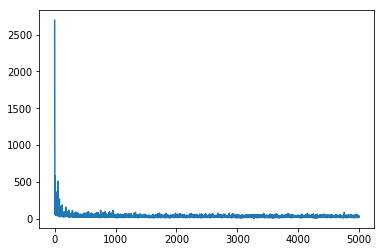

In [18]:
plt.figure()
plt.plot(losses)
plt.show()

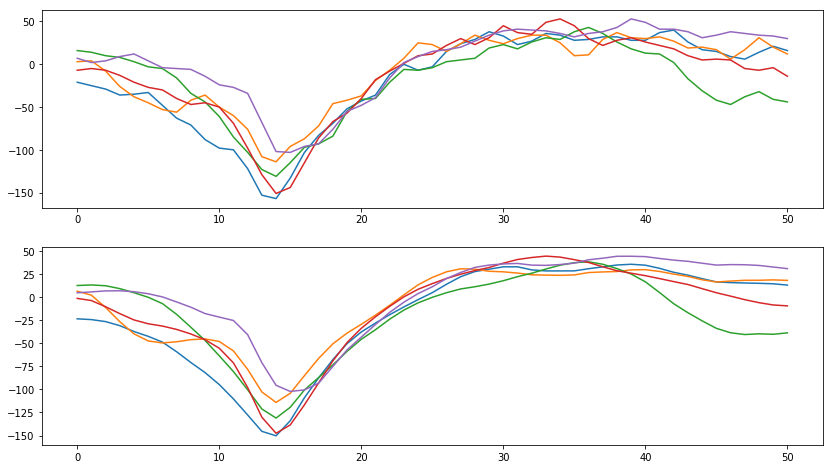

In [19]:
plt.figure(figsize=(14,8))

# n = [1, 30, 45, 50, 65]
n = [3490, 1098, 2377, 9, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    enc, o = ae_1.forward(data)
    o = (o.data).cpu().numpy()
    plt.subplot(211)
    plt.plot(electrode_data_test[i, :])
    plt.subplot(212)
    plt.plot(o)
plt.show()

In [20]:
torch.save(ae_1, 'models/visapy/ae_01072018.pt') #Saving the autoencoder model

## Using GANs for super-resolution

### Designing the GAN

In [21]:
class generator(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(generator, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, 28),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 16),
                                     activation_layer,
                                     nn.Linear(16, 25),
                                     activation_layer,
                                     nn.Linear(25, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [22]:
class discriminator(nn.Module):
    def __init__(self, input_size):
        super(discriminator, self).__init__()
        self.detect = nn.Sequential(nn.Linear(input_size, 32),
                                    nn.ELU(),
                                    nn.Linear(32, 16),
                                    nn.ELU(),
                                    nn.Linear(16, 4),
                                    nn.ELU(),
                                    nn.Linear(4, 1),
                                    nn.Sigmoid())
    def forward(self, x):
        out = self.detect(x)
        return out

In [23]:
# Using Trick 4 - Diffferent mini-batches of real and fake data for training

random.seed(0)

def train_gan(disc, gen, input_data, d_criterion, g_criterion, d_optimizer, g_optimizer, epoch_range,  
              batch_size_d, batch_size_g):
    for num_epoch in range(epoch_range):
        
        d_selected = random.sample(range(0, input_data.shape[0]), batch_size_d)

        for feats in d_selected:
            #---------Training the discriminator on real data------#
            real_data = input_data[feats, :]
            real_data = torch.from_numpy(real_data).float().cuda()
            #---------FORWARD------------#
            real_decision = disc.forward(real_data)
            real_decision = torch.tensor(real_decision).float().cuda()
            real_loss = d_criterion(real_decision, Variable(torch.ones(1)).cuda())
            #---------BACKWARD------------#
            real_loss.backward()
            
            d_optimizer.zero_grad()            
            d_optimizer.step()
        
        d_selected = random.sample(range(0, input_data.shape[0]), batch_size_d)
        
        for feats in d_selected:
            
            #---------Training the discriminator on fake data------#
            enc, fake_data = gen.forward(real_data)
            fake_data = torch.tensor(fake_data).float().cuda()
            #---------FORWARD------------#
            fake_decision = disc.forward(fake_data)
            fake_decision = torch.tensor(fake_decision).float().cuda()
            fake_loss = d_criterion(fake_decision, Variable(torch.zeros(1)).cuda())
            #---------BACKWARD------------#
            fake_loss.backward()
            
            d_optimizer.zero_grad()            
            d_optimizer.step()
        
        g_selected = random.sample(range(0, input_data.shape[0]), batch_size_g)
        
        for feats in g_selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = gen.forward(x)
            out = torch.tensor(out).float().cuda()
            g_loss = g_criterion(out, x)
            #---------BACKWARD------------#
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
        print('epoch [{}/{}], disc_real_loss:{:.4f}, disc_fake_loss:{:.4f}, gen_loss:{:.4f}'.format(num_epoch + 1, 
                                                    epoch_range, real_loss.data[0], fake_loss.data[0], g_loss.data[0]))
    return out

In [24]:
def init_gan_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

In [25]:
epoch_range = 400
batch_size_d = 150
batch_size_g = 100
g_learning_rate = 0.0001
d_learning_rate = 0.0001

# Defining the models
gen = generator(length, embedding_size).cuda()
disc = discriminator(length).cuda()

# Initialising the weights
gen.apply(init_gan_weights)
disc.apply(init_gan_weights)

# Setting up the loss criteria
g_criterion = nn.MSELoss()
d_criterion = nn.BCELoss()

# Setting up the Optimizer (Using Adam here)
g_optimizer = torch.optim.Adam(
    gen.parameters(), lr=g_learning_rate, weight_decay=0.001)
d_optimizer = torch.optim.Adam(
    disc.parameters(), lr=d_learning_rate, weight_decay=0.001)

out = train_gan(disc, gen, electrode_data_train, d_criterion, g_criterion, 
                             d_optimizer, g_optimizer, epoch_range, batch_size_d, batch_size_g)

epoch [1/400], disc_real_loss:27.6310, disc_fake_loss:0.3612, gen_loss:2619.2620
epoch [2/400], disc_real_loss:18.3074, disc_fake_loss:0.0000, gen_loss:1740.1268
epoch [3/400], disc_real_loss:10.6993, disc_fake_loss:0.0008, gen_loss:712.4047
epoch [4/400], disc_real_loss:23.4599, disc_fake_loss:0.0000, gen_loss:142.1964
epoch [5/400], disc_real_loss:16.5262, disc_fake_loss:0.0000, gen_loss:175.3190
epoch [6/400], disc_real_loss:3.1796, disc_fake_loss:0.0029, gen_loss:260.5960
epoch [7/400], disc_real_loss:4.1443, disc_fake_loss:0.0047, gen_loss:187.6189
epoch [8/400], disc_real_loss:10.0922, disc_fake_loss:0.0073, gen_loss:90.4738
epoch [9/400], disc_real_loss:2.6618, disc_fake_loss:0.1072, gen_loss:75.6567
epoch [10/400], disc_real_loss:0.6231, disc_fake_loss:0.2196, gen_loss:142.6722
epoch [11/400], disc_real_loss:2.2165, disc_fake_loss:0.2913, gen_loss:59.7447
epoch [12/400], disc_real_loss:0.8932, disc_fake_loss:0.3043, gen_loss:184.4031
epoch [13/400], disc_real_loss:1.1404, disc_

epoch [105/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:56.6819
epoch [106/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:39.2293
epoch [107/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:88.0651
epoch [108/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:70.4796
epoch [109/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:193.5874
epoch [110/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:72.6194
epoch [111/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:52.5155
epoch [112/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:33.8008
epoch [113/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:57.1360
epoch [114/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:259.5716
epoch [115/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:49.2924
epoch [116/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:175.6429
epoch [117/400], disc_real_loss:0.693

epoch [208/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:91.9663
epoch [209/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:32.5573
epoch [210/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:45.1735
epoch [211/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:27.5516
epoch [212/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:48.6182
epoch [213/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:50.1526
epoch [214/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:35.9046
epoch [215/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:71.5360
epoch [216/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:55.1701
epoch [217/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:24.0677
epoch [218/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:52.9253
epoch [219/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:63.1227
epoch [220/400], disc_real_loss:0.6931, 

epoch [311/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:33.5396
epoch [312/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:40.3302
epoch [313/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:41.0283
epoch [314/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:63.3932
epoch [315/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:25.6648
epoch [316/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:53.0204
epoch [317/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:43.6631
epoch [318/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:47.3638
epoch [319/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:49.9205
epoch [320/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:33.1876
epoch [321/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:43.1278
epoch [322/400], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:37.2877
epoch [323/400], disc_real_loss:0.6931, 

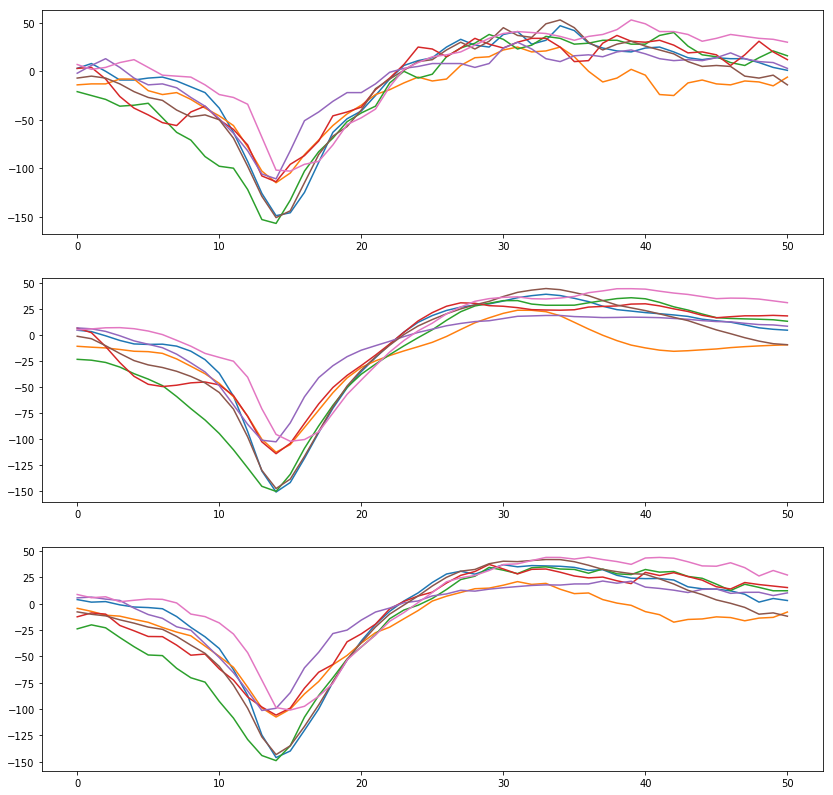

In [28]:
plt.figure(figsize=(14,14))

# n = [1, 30, 45, 50, 65]
n = [11, 290, 3490, 1098, 2707, 9, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    enc, o = ae_1.forward(data)
    o = (o.data).cpu().numpy()
    #print(np.sum(np.subtract(electrode_data_test[i, :], o)))
    enc, o_gan = gen.forward(data)
    o_gan = (o_gan.data).cpu().numpy()
    #print(np.sum(np.subtract(electrode_data_test[i, :], o_gan)))
    #print('-----------------')
    plt.subplot(311)
    plt.plot(electrode_data_test[i, :])
    plt.subplot(312)
    plt.plot(o)
    plt.subplot(313)
    plt.plot(o_gan)
plt.show()

In [27]:
torch.save(gen, 'models/visapy/gan_01072018.pt') #Saving the autoencoder model

## Designing LSTM-Autoencoders

In [35]:
class lstm_autoencoder(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(lstm_autoencoder, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.LSTM(input_size=input_size, hidden_size=75, num_layers=2, bidirectional=True),
                                     activation_layer,
                                     nn.LSTM(input_size=75, hidden_size=28, num_layers=2, bidirectional=True),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.LSTM(input_size=embedding_size, hidden_size=16, num_layers=2, bidirectional=True),
                                     activation_layer,
                                     nn.LSTM(input_size=16, hidden_size=25, num_layers=2, bidirectional=True),
                                     activation_layer,
                                     nn.Linear(25, input_size))    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [36]:
random.seed(0)

def train_lstm(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        for feats in selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = model.forward(x)
            out = torch.tensor(out).float().cuda()
            loss = criterion(out, x)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.data[0])
        print('epoch [{}/{}], loss:{:.5f}, avg:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], sum(losses[-10:])/len(losses[-10:])))
    return enc, out, losses

In [37]:
def init_gan_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.LSTM:
        nn.init.xavier_normal_(layer.weight)

In [38]:
epoch_range = 5000
batch_size = 150
learning_rate = 0.0001

lstm_ae = autoencoder(length, embedding_size).cuda()
lstm_ae.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    lstm_ae.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses = train_lstm(lstm_ae, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/5000], loss:2100.60571, avg:2100.60571
epoch [2/5000], loss:655.85284, avg:1378.22925
epoch [3/5000], loss:326.05826, avg:1027.50562
epoch [4/5000], loss:82.45477, avg:791.24292
epoch [5/5000], loss:115.74339, avg:656.14301
epoch [6/5000], loss:69.23036, avg:558.32428
epoch [7/5000], loss:327.91064, avg:525.40808
epoch [8/5000], loss:129.34273, avg:475.89987
epoch [9/5000], loss:251.58035, avg:450.97549
epoch [10/5000], loss:449.16855, avg:450.79477
epoch [11/5000], loss:54.58104, avg:246.19229
epoch [12/5000], loss:140.25261, avg:194.63226
epoch [13/5000], loss:77.15723, avg:169.74217
epoch [14/5000], loss:42.18153, avg:165.71484
epoch [15/5000], loss:267.17471, avg:180.85797
epoch [16/5000], loss:186.15564, avg:192.55051
epoch [17/5000], loss:71.86534, avg:166.94597
epoch [18/5000], loss:199.95840, avg:174.00755
epoch [19/5000], loss:67.86982, avg:155.63649
epoch [20/5000], loss:72.84162, avg:118.00381
epoch [21/5000], loss:169.77271, avg:129.52298
epoch [22/5000], loss:48.5

epoch [180/5000], loss:25.86144, avg:40.98182
epoch [181/5000], loss:32.63809, avg:41.79494
epoch [182/5000], loss:48.83984, avg:42.30507
epoch [183/5000], loss:50.68277, avg:43.08734
epoch [184/5000], loss:34.31064, avg:40.47291
epoch [185/5000], loss:82.00719, avg:44.96149
epoch [186/5000], loss:213.70770, avg:62.00184
epoch [187/5000], loss:42.91728, avg:62.36214
epoch [188/5000], loss:33.16216, avg:59.99057
epoch [189/5000], loss:60.59774, avg:62.47248
epoch [190/5000], loss:34.94315, avg:63.38065
epoch [191/5000], loss:63.83180, avg:66.50002
epoch [192/5000], loss:34.68176, avg:65.08422
epoch [193/5000], loss:59.01387, avg:65.91733
epoch [194/5000], loss:30.03325, avg:65.48959
epoch [195/5000], loss:58.89119, avg:63.17799
epoch [196/5000], loss:57.72527, avg:47.57974
epoch [197/5000], loss:51.77552, avg:48.46557
epoch [198/5000], loss:49.78109, avg:50.12746
epoch [199/5000], loss:60.54928, avg:50.12262
epoch [200/5000], loss:58.00952, avg:52.42926
epoch [201/5000], loss:42.06791, 

epoch [359/5000], loss:42.62495, avg:36.77717
epoch [360/5000], loss:33.62671, avg:37.48055
epoch [361/5000], loss:30.57143, avg:37.27197
epoch [362/5000], loss:38.56093, avg:38.46613
epoch [363/5000], loss:33.04409, avg:37.44926
epoch [364/5000], loss:28.98878, avg:32.93344
epoch [365/5000], loss:40.67763, avg:34.02957
epoch [366/5000], loss:37.89729, avg:34.32669
epoch [367/5000], loss:86.73080, avg:40.62314
epoch [368/5000], loss:24.26413, avg:39.69867
epoch [369/5000], loss:44.71603, avg:39.90778
epoch [370/5000], loss:22.42670, avg:38.78778
epoch [371/5000], loss:20.83749, avg:37.81439
epoch [372/5000], loss:45.80963, avg:38.53926
epoch [373/5000], loss:29.49532, avg:38.18438
epoch [374/5000], loss:36.61244, avg:38.94675
epoch [375/5000], loss:56.79399, avg:40.55839
epoch [376/5000], loss:44.07394, avg:41.17605
epoch [377/5000], loss:39.61253, avg:36.46422
epoch [378/5000], loss:74.95593, avg:41.53340
epoch [379/5000], loss:69.01630, avg:43.96342
epoch [380/5000], loss:23.48454, a

epoch [538/5000], loss:25.09168, avg:32.06362
epoch [539/5000], loss:27.18906, avg:32.64009
epoch [540/5000], loss:38.91382, avg:32.04315
epoch [541/5000], loss:56.02667, avg:34.13356
epoch [542/5000], loss:36.59286, avg:35.47831
epoch [543/5000], loss:58.86136, avg:38.76696
epoch [544/5000], loss:37.52089, avg:37.69989
epoch [545/5000], loss:34.28657, avg:38.00547
epoch [546/5000], loss:33.90042, avg:39.55783
epoch [547/5000], loss:23.98804, avg:37.23713
epoch [548/5000], loss:37.13022, avg:38.44099
epoch [549/5000], loss:35.89610, avg:39.31170
epoch [550/5000], loss:43.87427, avg:39.80774
epoch [551/5000], loss:55.73297, avg:39.77837
epoch [552/5000], loss:64.76817, avg:42.59590
epoch [553/5000], loss:28.66074, avg:39.57584
epoch [554/5000], loss:49.90746, avg:40.81450
epoch [555/5000], loss:50.54103, avg:42.43995
epoch [556/5000], loss:42.92847, avg:43.34275
epoch [557/5000], loss:41.39577, avg:45.08352
epoch [558/5000], loss:37.04897, avg:45.07540
epoch [559/5000], loss:45.56409, a

epoch [717/5000], loss:28.28721, avg:38.41368
epoch [718/5000], loss:27.95571, avg:38.13050
epoch [719/5000], loss:23.90624, avg:33.39232
epoch [720/5000], loss:17.08728, avg:31.02216
epoch [721/5000], loss:30.73650, avg:31.81955
epoch [722/5000], loss:19.30857, avg:30.12142
epoch [723/5000], loss:38.56973, avg:28.90689
epoch [724/5000], loss:39.72012, avg:28.34851
epoch [725/5000], loss:30.82785, avg:28.94274
epoch [726/5000], loss:32.85607, avg:28.92553
epoch [727/5000], loss:29.30982, avg:29.02779
epoch [728/5000], loss:36.11023, avg:29.84324
epoch [729/5000], loss:51.52524, avg:32.60514
epoch [730/5000], loss:41.34355, avg:35.03077
epoch [731/5000], loss:33.84069, avg:35.34118
epoch [732/5000], loss:45.81376, avg:37.99170
epoch [733/5000], loss:23.55366, avg:36.49010
epoch [734/5000], loss:31.22824, avg:35.64091
epoch [735/5000], loss:26.00468, avg:35.15859
epoch [736/5000], loss:32.83561, avg:35.15654
epoch [737/5000], loss:49.06285, avg:37.13185
epoch [738/5000], loss:11.56310, a

epoch [896/5000], loss:19.99785, avg:32.81203
epoch [897/5000], loss:14.87147, avg:31.28115
epoch [898/5000], loss:44.17597, avg:31.96879
epoch [899/5000], loss:26.54439, avg:32.21423
epoch [900/5000], loss:24.72105, avg:26.74564
epoch [901/5000], loss:98.01107, avg:34.00151
epoch [902/5000], loss:44.11897, avg:35.36363
epoch [903/5000], loss:29.27612, avg:35.41220
epoch [904/5000], loss:27.54971, avg:35.72772
epoch [905/5000], loss:28.90866, avg:35.81753
epoch [906/5000], loss:45.54707, avg:38.37245
epoch [907/5000], loss:22.97854, avg:39.18316
epoch [908/5000], loss:24.39479, avg:37.20504
epoch [909/5000], loss:11.85406, avg:35.73600
epoch [910/5000], loss:24.48619, avg:35.71252
epoch [911/5000], loss:34.74421, avg:29.38583
epoch [912/5000], loss:47.59780, avg:29.73372
epoch [913/5000], loss:30.05289, avg:29.81139
epoch [914/5000], loss:29.47193, avg:30.00361
epoch [915/5000], loss:16.12491, avg:28.72524
epoch [916/5000], loss:22.23315, avg:26.39385
epoch [917/5000], loss:22.59215, a

epoch [1073/5000], loss:42.47052, avg:30.32097
epoch [1074/5000], loss:16.65094, avg:28.90181
epoch [1075/5000], loss:21.56372, avg:26.18881
epoch [1076/5000], loss:34.88866, avg:27.96443
epoch [1077/5000], loss:15.21868, avg:27.34727
epoch [1078/5000], loss:24.04497, avg:25.92639
epoch [1079/5000], loss:36.80880, avg:27.20272
epoch [1080/5000], loss:54.71296, avg:29.46417
epoch [1081/5000], loss:19.92579, avg:29.14206
epoch [1082/5000], loss:34.78678, avg:30.10718
epoch [1083/5000], loss:30.09728, avg:28.86986
epoch [1084/5000], loss:20.97988, avg:29.30276
epoch [1085/5000], loss:26.66380, avg:29.81276
epoch [1086/5000], loss:25.75816, avg:28.89971
epoch [1087/5000], loss:50.61911, avg:32.43975
epoch [1088/5000], loss:18.93266, avg:31.92853
epoch [1089/5000], loss:47.06721, avg:32.95436
epoch [1090/5000], loss:34.65801, avg:30.94887
epoch [1091/5000], loss:25.39802, avg:31.49609
epoch [1092/5000], loss:29.41533, avg:30.95894
epoch [1093/5000], loss:34.32304, avg:31.38152
epoch [1094/5

epoch [1248/5000], loss:15.76405, avg:33.50221
epoch [1249/5000], loss:17.28001, avg:30.78235
epoch [1250/5000], loss:35.20261, avg:31.19018
epoch [1251/5000], loss:21.85944, avg:30.64714
epoch [1252/5000], loss:38.07851, avg:31.54358
epoch [1253/5000], loss:52.97091, avg:33.68836
epoch [1254/5000], loss:27.84441, avg:33.84206
epoch [1255/5000], loss:42.25997, avg:35.22898
epoch [1256/5000], loss:70.42395, avg:35.21774
epoch [1257/5000], loss:36.33874, avg:35.80226
epoch [1258/5000], loss:20.50988, avg:36.27684
epoch [1259/5000], loss:31.96291, avg:37.74514
epoch [1260/5000], loss:26.46070, avg:36.87094
epoch [1261/5000], loss:44.60676, avg:39.14567
epoch [1262/5000], loss:18.31021, avg:37.16884
epoch [1263/5000], loss:33.32558, avg:35.20431
epoch [1264/5000], loss:35.42575, avg:35.96244
epoch [1265/5000], loss:16.95992, avg:33.43244
epoch [1266/5000], loss:22.14931, avg:28.60497
epoch [1267/5000], loss:28.29664, avg:27.80076
epoch [1268/5000], loss:29.56610, avg:28.70639
epoch [1269/5

epoch [1423/5000], loss:38.18225, avg:27.94704
epoch [1424/5000], loss:38.89983, avg:30.00298
epoch [1425/5000], loss:18.99635, avg:29.94573
epoch [1426/5000], loss:40.05716, avg:30.24553
epoch [1427/5000], loss:19.47781, avg:28.17084
epoch [1428/5000], loss:37.52023, avg:30.09994
epoch [1429/5000], loss:18.05513, avg:28.42435
epoch [1430/5000], loss:33.26805, avg:29.77792
epoch [1431/5000], loss:28.16472, avg:30.22744
epoch [1432/5000], loss:28.50818, avg:30.11297
epoch [1433/5000], loss:40.55905, avg:30.35065
epoch [1434/5000], loss:25.63038, avg:29.02371
epoch [1435/5000], loss:39.93607, avg:31.11768
epoch [1436/5000], loss:33.25792, avg:30.43776
epoch [1437/5000], loss:39.15959, avg:32.40593
epoch [1438/5000], loss:19.91298, avg:30.64521
epoch [1439/5000], loss:17.88153, avg:30.62785
epoch [1440/5000], loss:27.94589, avg:30.09563
epoch [1441/5000], loss:20.71550, avg:29.35071
epoch [1442/5000], loss:16.29969, avg:28.12986
epoch [1443/5000], loss:27.58511, avg:26.83246
epoch [1444/5

epoch [1598/5000], loss:33.05747, avg:27.06416
epoch [1599/5000], loss:15.72773, avg:26.19745
epoch [1600/5000], loss:12.66489, avg:25.94904
epoch [1601/5000], loss:24.13096, avg:25.09427
epoch [1602/5000], loss:26.89411, avg:24.28200
epoch [1603/5000], loss:29.67289, avg:24.75728
epoch [1604/5000], loss:27.48070, avg:24.31272
epoch [1605/5000], loss:28.95326, avg:24.39649
epoch [1606/5000], loss:26.13736, avg:24.19823
epoch [1607/5000], loss:26.52479, avg:25.12442
epoch [1608/5000], loss:36.46289, avg:25.46496
epoch [1609/5000], loss:25.91159, avg:26.48334
epoch [1610/5000], loss:27.26383, avg:27.94324
epoch [1611/5000], loss:17.10006, avg:27.24015
epoch [1612/5000], loss:49.23614, avg:29.47435
epoch [1613/5000], loss:42.88856, avg:30.79592
epoch [1614/5000], loss:32.44493, avg:31.29234
epoch [1615/5000], loss:11.48178, avg:29.54519
epoch [1616/5000], loss:30.18948, avg:29.95040
epoch [1617/5000], loss:27.46341, avg:30.04427
epoch [1618/5000], loss:17.27560, avg:28.12554
epoch [1619/5

epoch [1773/5000], loss:26.52450, avg:28.74542
epoch [1774/5000], loss:43.90162, avg:30.02705
epoch [1775/5000], loss:33.90552, avg:31.54986
epoch [1776/5000], loss:42.00583, avg:33.00586
epoch [1777/5000], loss:26.86158, avg:34.42960
epoch [1778/5000], loss:40.56858, avg:36.39689
epoch [1779/5000], loss:19.26059, avg:34.77588
epoch [1780/5000], loss:22.97226, avg:33.29494
epoch [1781/5000], loss:19.99584, avg:31.43414
epoch [1782/5000], loss:24.41872, avg:30.04150
epoch [1783/5000], loss:21.65903, avg:29.55496
epoch [1784/5000], loss:43.99348, avg:29.56414
epoch [1785/5000], loss:20.52601, avg:28.22619
epoch [1786/5000], loss:33.34427, avg:27.36003
epoch [1787/5000], loss:11.16800, avg:25.79068
epoch [1788/5000], loss:33.33770, avg:25.06759
epoch [1789/5000], loss:27.78893, avg:25.92043
epoch [1790/5000], loss:17.41728, avg:25.36493
epoch [1791/5000], loss:38.18445, avg:27.18379
epoch [1792/5000], loss:19.93243, avg:26.73516
epoch [1793/5000], loss:27.11599, avg:27.28085
epoch [1794/5

epoch [1948/5000], loss:53.25177, avg:29.80472
epoch [1949/5000], loss:36.17670, avg:31.64067
epoch [1950/5000], loss:24.49350, avg:31.63016
epoch [1951/5000], loss:50.32041, avg:33.18198
epoch [1952/5000], loss:23.14461, avg:33.24763
epoch [1953/5000], loss:16.13168, avg:31.11429
epoch [1954/5000], loss:45.51227, avg:31.65616
epoch [1955/5000], loss:27.78291, avg:32.16914
epoch [1956/5000], loss:32.01844, avg:33.46460
epoch [1957/5000], loss:33.52079, avg:34.23531
epoch [1958/5000], loss:30.44999, avg:31.95513
epoch [1959/5000], loss:10.44550, avg:29.38201
epoch [1960/5000], loss:34.04775, avg:30.33744
epoch [1961/5000], loss:27.33319, avg:28.03872
epoch [1962/5000], loss:27.37196, avg:28.46145
epoch [1963/5000], loss:22.25424, avg:29.07370
epoch [1964/5000], loss:34.67789, avg:27.99026
epoch [1965/5000], loss:24.40931, avg:27.65291
epoch [1966/5000], loss:19.80534, avg:26.43160
epoch [1967/5000], loss:19.88472, avg:25.06799
epoch [1968/5000], loss:46.60447, avg:26.68344
epoch [1969/5

epoch [2123/5000], loss:22.09367, avg:28.64995
epoch [2124/5000], loss:21.60319, avg:27.63938
epoch [2125/5000], loss:36.02659, avg:27.45823
epoch [2126/5000], loss:32.91599, avg:28.64876
epoch [2127/5000], loss:25.40553, avg:29.54154
epoch [2128/5000], loss:26.83548, avg:30.82313
epoch [2129/5000], loss:16.13317, avg:29.62356
epoch [2130/5000], loss:40.13137, avg:29.02388
epoch [2131/5000], loss:106.29116, avg:36.28637
epoch [2132/5000], loss:15.27489, avg:34.27110
epoch [2133/5000], loss:29.71228, avg:35.03297
epoch [2134/5000], loss:35.56627, avg:36.42927
epoch [2135/5000], loss:29.70577, avg:35.79720
epoch [2136/5000], loss:25.73486, avg:35.07907
epoch [2137/5000], loss:20.81763, avg:34.62029
epoch [2138/5000], loss:18.06199, avg:33.74294
epoch [2139/5000], loss:30.34443, avg:35.16406
epoch [2140/5000], loss:32.27045, avg:34.37797
epoch [2141/5000], loss:31.10075, avg:26.85893
epoch [2142/5000], loss:19.64682, avg:27.29613
epoch [2143/5000], loss:17.00568, avg:26.02547
epoch [2144/

epoch [2298/5000], loss:28.83697, avg:31.19160
epoch [2299/5000], loss:19.74918, avg:28.52983
epoch [2300/5000], loss:30.62917, avg:28.59406
epoch [2301/5000], loss:14.02008, avg:25.81095
epoch [2302/5000], loss:38.16459, avg:27.59898
epoch [2303/5000], loss:28.61051, avg:28.63756
epoch [2304/5000], loss:17.61753, avg:27.13338
epoch [2305/5000], loss:23.32580, avg:25.06434
epoch [2306/5000], loss:22.76357, avg:26.02428
epoch [2307/5000], loss:48.03675, avg:27.17542
epoch [2308/5000], loss:25.29243, avg:26.82096
epoch [2309/5000], loss:29.13884, avg:27.75993
epoch [2310/5000], loss:21.92775, avg:26.88979
epoch [2311/5000], loss:27.86613, avg:28.27439
epoch [2312/5000], loss:28.39851, avg:27.29778
epoch [2313/5000], loss:24.69541, avg:26.90627
epoch [2314/5000], loss:23.11589, avg:27.45611
epoch [2315/5000], loss:26.23715, avg:27.74724
epoch [2316/5000], loss:36.43456, avg:29.11434
epoch [2317/5000], loss:30.83325, avg:27.39399
epoch [2318/5000], loss:21.23904, avg:26.98865
epoch [2319/5

epoch [2473/5000], loss:13.14533, avg:22.73129
epoch [2474/5000], loss:23.90380, avg:23.38106
epoch [2475/5000], loss:64.41090, avg:27.60072
epoch [2476/5000], loss:21.19111, avg:28.35262
epoch [2477/5000], loss:16.14830, avg:28.12365
epoch [2478/5000], loss:47.00264, avg:30.02813
epoch [2479/5000], loss:25.68567, avg:30.22844
epoch [2480/5000], loss:48.43155, avg:32.76522
epoch [2481/5000], loss:17.53565, avg:31.63372
epoch [2482/5000], loss:26.38305, avg:30.38380
epoch [2483/5000], loss:62.13005, avg:35.28228
epoch [2484/5000], loss:22.90375, avg:35.18227
epoch [2485/5000], loss:29.35539, avg:31.67672
epoch [2486/5000], loss:20.87523, avg:31.64513
epoch [2487/5000], loss:30.15748, avg:33.04605
epoch [2488/5000], loss:61.31778, avg:34.47756
epoch [2489/5000], loss:36.17966, avg:35.52696
epoch [2490/5000], loss:26.94363, avg:33.37817
epoch [2491/5000], loss:30.39639, avg:34.66424
epoch [2492/5000], loss:26.59024, avg:34.68496
epoch [2493/5000], loss:50.13625, avg:33.48558
epoch [2494/5

epoch [2648/5000], loss:30.21258, avg:28.32199
epoch [2649/5000], loss:27.55213, avg:29.35336
epoch [2650/5000], loss:22.81690, avg:27.58266
epoch [2651/5000], loss:29.21170, avg:26.65732
epoch [2652/5000], loss:34.03276, avg:27.65490
epoch [2653/5000], loss:22.17381, avg:26.54166
epoch [2654/5000], loss:25.63489, avg:26.40981
epoch [2655/5000], loss:17.18549, avg:24.50739
epoch [2656/5000], loss:19.34142, avg:24.45878
epoch [2657/5000], loss:32.95470, avg:26.11164
epoch [2658/5000], loss:26.24506, avg:25.71489
epoch [2659/5000], loss:28.08049, avg:25.76772
epoch [2660/5000], loss:30.31381, avg:26.51741
epoch [2661/5000], loss:29.39179, avg:26.53543
epoch [2662/5000], loss:42.87029, avg:27.41917
epoch [2663/5000], loss:33.14227, avg:28.51602
epoch [2664/5000], loss:28.80501, avg:28.83303
epoch [2665/5000], loss:26.09250, avg:29.72373
epoch [2666/5000], loss:20.11299, avg:29.80089
epoch [2667/5000], loss:18.06133, avg:28.31155
epoch [2668/5000], loss:31.48656, avg:28.83571
epoch [2669/5

epoch [2823/5000], loss:25.65427, avg:27.31316
epoch [2824/5000], loss:25.64202, avg:27.62638
epoch [2825/5000], loss:23.26629, avg:27.69810
epoch [2826/5000], loss:33.75356, avg:27.34009
epoch [2827/5000], loss:34.07389, avg:27.65201
epoch [2828/5000], loss:23.24028, avg:26.17429
epoch [2829/5000], loss:24.06553, avg:26.26888
epoch [2830/5000], loss:35.30594, avg:27.68870
epoch [2831/5000], loss:34.15919, avg:28.22507
epoch [2832/5000], loss:25.57042, avg:28.47314
epoch [2833/5000], loss:25.86686, avg:28.49440
epoch [2834/5000], loss:20.45672, avg:27.97587
epoch [2835/5000], loss:18.66207, avg:27.51545
epoch [2836/5000], loss:13.49587, avg:25.48968
epoch [2837/5000], loss:20.11723, avg:24.09401
epoch [2838/5000], loss:33.60089, avg:25.13008
epoch [2839/5000], loss:26.87297, avg:25.41082
epoch [2840/5000], loss:30.93078, avg:24.97330
epoch [2841/5000], loss:12.92899, avg:22.85028
epoch [2842/5000], loss:28.80729, avg:23.17397
epoch [2843/5000], loss:18.35588, avg:22.42287
epoch [2844/5

epoch [2998/5000], loss:59.35183, avg:28.79174
epoch [2999/5000], loss:29.88492, avg:29.01400
epoch [3000/5000], loss:26.53425, avg:29.38341
epoch [3001/5000], loss:31.37271, avg:29.32983
epoch [3002/5000], loss:40.59589, avg:32.34867
epoch [3003/5000], loss:16.60291, avg:31.69365
epoch [3004/5000], loss:34.53284, avg:32.12907
epoch [3005/5000], loss:31.48462, avg:33.15979
epoch [3006/5000], loss:18.84326, avg:31.26810
epoch [3007/5000], loss:32.59015, avg:32.17934
epoch [3008/5000], loss:26.05057, avg:28.84921
epoch [3009/5000], loss:17.54374, avg:27.61510
epoch [3010/5000], loss:19.30405, avg:26.89207
epoch [3011/5000], loss:30.41024, avg:26.79583
epoch [3012/5000], loss:21.30369, avg:24.86661
epoch [3013/5000], loss:25.25086, avg:25.73140
epoch [3014/5000], loss:20.10460, avg:24.28858
epoch [3015/5000], loss:28.93360, avg:24.03348
epoch [3016/5000], loss:21.61265, avg:24.31042
epoch [3017/5000], loss:36.61193, avg:24.71259
epoch [3018/5000], loss:21.37261, avg:24.24479
epoch [3019/5

epoch [3173/5000], loss:48.50089, avg:34.29212
epoch [3174/5000], loss:23.30300, avg:34.17844
epoch [3175/5000], loss:39.54628, avg:34.53341
epoch [3176/5000], loss:38.72699, avg:36.73051
epoch [3177/5000], loss:45.78316, avg:37.67907
epoch [3178/5000], loss:17.23604, avg:33.69260
epoch [3179/5000], loss:20.42871, avg:34.29877
epoch [3180/5000], loss:22.34687, avg:32.37784
epoch [3181/5000], loss:27.72694, avg:31.40533
epoch [3182/5000], loss:42.55443, avg:32.61533
epoch [3183/5000], loss:40.26472, avg:31.79172
epoch [3184/5000], loss:19.99140, avg:31.46056
epoch [3185/5000], loss:45.47853, avg:32.05378
epoch [3186/5000], loss:28.65618, avg:31.04670
epoch [3187/5000], loss:28.01002, avg:29.26938
epoch [3188/5000], loss:23.69053, avg:29.91483
epoch [3189/5000], loss:16.72464, avg:29.54443
epoch [3190/5000], loss:18.41657, avg:29.15140
epoch [3191/5000], loss:15.48240, avg:27.92694
epoch [3192/5000], loss:20.80933, avg:25.75243
epoch [3193/5000], loss:15.98136, avg:23.32410
epoch [3194/5

epoch [3348/5000], loss:22.26740, avg:27.67030
epoch [3349/5000], loss:22.07344, avg:26.32680
epoch [3350/5000], loss:47.91594, avg:28.07395
epoch [3351/5000], loss:15.83075, avg:27.61943
epoch [3352/5000], loss:30.02198, avg:28.15868
epoch [3353/5000], loss:15.03463, avg:26.32348
epoch [3354/5000], loss:28.31653, avg:26.70500
epoch [3355/5000], loss:21.15024, avg:26.34258
epoch [3356/5000], loss:12.67782, avg:24.54556
epoch [3357/5000], loss:35.32219, avg:25.06109
epoch [3358/5000], loss:13.54163, avg:24.18851
epoch [3359/5000], loss:16.86771, avg:23.66794
epoch [3360/5000], loss:40.86291, avg:22.96264
epoch [3361/5000], loss:31.28787, avg:24.50835
epoch [3362/5000], loss:25.09878, avg:24.01603
epoch [3363/5000], loss:32.11199, avg:25.72377
epoch [3364/5000], loss:20.08047, avg:24.90017
epoch [3365/5000], loss:13.81480, avg:24.16662
epoch [3366/5000], loss:25.20988, avg:25.41982
epoch [3367/5000], loss:33.73988, avg:25.26159
epoch [3368/5000], loss:47.62583, avg:28.67002
epoch [3369/5

epoch [3523/5000], loss:14.43968, avg:26.53577
epoch [3524/5000], loss:25.96303, avg:24.82816
epoch [3525/5000], loss:28.63197, avg:25.94473
epoch [3526/5000], loss:22.35447, avg:26.87363
epoch [3527/5000], loss:14.95999, avg:24.43251
epoch [3528/5000], loss:25.27314, avg:24.12800
epoch [3529/5000], loss:29.80426, avg:23.81485
epoch [3530/5000], loss:33.30690, avg:23.98223
epoch [3531/5000], loss:23.93806, avg:24.52819
epoch [3532/5000], loss:27.06177, avg:24.57333
epoch [3533/5000], loss:36.34091, avg:26.76345
epoch [3534/5000], loss:22.43389, avg:26.41054
epoch [3535/5000], loss:53.32323, avg:28.87966
epoch [3536/5000], loss:15.30678, avg:28.17489
epoch [3537/5000], loss:36.21572, avg:30.30047
epoch [3538/5000], loss:12.28548, avg:29.00170
epoch [3539/5000], loss:29.03419, avg:28.92469
epoch [3540/5000], loss:30.63960, avg:28.65796
epoch [3541/5000], loss:22.00676, avg:28.46484
epoch [3542/5000], loss:27.23331, avg:28.48199
epoch [3543/5000], loss:22.15688, avg:27.06359
epoch [3544/5

epoch [3698/5000], loss:32.20846, avg:22.06560
epoch [3699/5000], loss:18.34397, avg:21.99193
epoch [3700/5000], loss:14.76417, avg:22.42895
epoch [3701/5000], loss:35.85463, avg:23.69375
epoch [3702/5000], loss:15.20707, avg:22.62249
epoch [3703/5000], loss:30.06979, avg:22.94183
epoch [3704/5000], loss:21.21584, avg:23.45114
epoch [3705/5000], loss:15.78720, avg:22.01107
epoch [3706/5000], loss:14.37722, avg:22.24108
epoch [3707/5000], loss:17.89463, avg:21.57230
epoch [3708/5000], loss:15.84188, avg:19.93564
epoch [3709/5000], loss:24.30281, avg:20.53152
epoch [3710/5000], loss:29.62448, avg:22.01756
epoch [3711/5000], loss:18.69523, avg:20.30162
epoch [3712/5000], loss:14.07873, avg:20.18878
epoch [3713/5000], loss:27.30366, avg:19.91217
epoch [3714/5000], loss:29.32903, avg:20.72349
epoch [3715/5000], loss:33.52789, avg:22.49755
epoch [3716/5000], loss:25.36044, avg:23.59588
epoch [3717/5000], loss:13.96637, avg:23.20305
epoch [3718/5000], loss:29.80631, avg:24.59949
epoch [3719/5

epoch [3873/5000], loss:21.41739, avg:30.33049
epoch [3874/5000], loss:10.75166, avg:27.13133
epoch [3875/5000], loss:28.33047, avg:26.93603
epoch [3876/5000], loss:17.16325, avg:24.81334
epoch [3877/5000], loss:22.94719, avg:23.14437
epoch [3878/5000], loss:37.24922, avg:25.07308
epoch [3879/5000], loss:20.49521, avg:23.81455
epoch [3880/5000], loss:26.11883, avg:23.62684
epoch [3881/5000], loss:27.20986, avg:24.21409
epoch [3882/5000], loss:36.96084, avg:24.86439
epoch [3883/5000], loss:17.62780, avg:24.48543
epoch [3884/5000], loss:27.51430, avg:26.16170
epoch [3885/5000], loss:25.50435, avg:25.87908
epoch [3886/5000], loss:22.95713, avg:26.45847
epoch [3887/5000], loss:31.85396, avg:27.34915
epoch [3888/5000], loss:20.08965, avg:25.63319
epoch [3889/5000], loss:32.48452, avg:26.83213
epoch [3890/5000], loss:23.95542, avg:26.61578
epoch [3891/5000], loss:28.51890, avg:26.74669
epoch [3892/5000], loss:30.68466, avg:26.11907
epoch [3893/5000], loss:48.74317, avg:29.23061
epoch [3894/5

epoch [4048/5000], loss:23.81539, avg:21.87110
epoch [4049/5000], loss:32.37749, avg:22.78461
epoch [4050/5000], loss:17.37086, avg:22.42393
epoch [4051/5000], loss:29.01427, avg:22.90302
epoch [4052/5000], loss:28.62585, avg:23.54612
epoch [4053/5000], loss:23.59238, avg:22.77040
epoch [4054/5000], loss:6.33820, avg:21.01580
epoch [4055/5000], loss:60.57307, avg:25.12180
epoch [4056/5000], loss:41.62416, avg:28.31648
epoch [4057/5000], loss:22.80789, avg:28.61396
epoch [4058/5000], loss:30.75208, avg:29.30762
epoch [4059/5000], loss:18.25250, avg:27.89513
epoch [4060/5000], loss:29.49426, avg:29.10747
epoch [4061/5000], loss:31.84224, avg:29.39026
epoch [4062/5000], loss:25.37536, avg:29.06521
epoch [4063/5000], loss:48.34136, avg:31.54011
epoch [4064/5000], loss:22.17043, avg:33.12334
epoch [4065/5000], loss:30.98300, avg:30.16433
epoch [4066/5000], loss:32.72055, avg:29.27397
epoch [4067/5000], loss:26.88065, avg:29.68124
epoch [4068/5000], loss:32.97127, avg:29.90316
epoch [4069/50

epoch [4223/5000], loss:32.99324, avg:30.65858
epoch [4224/5000], loss:20.41749, avg:28.59557
epoch [4225/5000], loss:20.72818, avg:27.41446
epoch [4226/5000], loss:31.40211, avg:28.80748
epoch [4227/5000], loss:23.39476, avg:28.06025
epoch [4228/5000], loss:14.06661, avg:24.60957
epoch [4229/5000], loss:46.50947, avg:26.55601
epoch [4230/5000], loss:33.67169, avg:26.85493
epoch [4231/5000], loss:39.68629, avg:29.00985
epoch [4232/5000], loss:21.51072, avg:28.43806
epoch [4233/5000], loss:40.93435, avg:29.23217
epoch [4234/5000], loss:21.91726, avg:29.38214
epoch [4235/5000], loss:20.75724, avg:29.38505
epoch [4236/5000], loss:26.67334, avg:28.91217
epoch [4237/5000], loss:41.54613, avg:30.72731
epoch [4238/5000], loss:34.51568, avg:32.77222
epoch [4239/5000], loss:26.82506, avg:30.80378
epoch [4240/5000], loss:28.56193, avg:30.29280
epoch [4241/5000], loss:26.32145, avg:28.95631
epoch [4242/5000], loss:24.35031, avg:29.24027
epoch [4243/5000], loss:25.20403, avg:27.66724
epoch [4244/5

epoch [4398/5000], loss:25.28985, avg:29.42750
epoch [4399/5000], loss:30.37320, avg:30.24516
epoch [4400/5000], loss:20.40424, avg:29.58102
epoch [4401/5000], loss:40.73112, avg:31.39897
epoch [4402/5000], loss:21.99229, avg:30.47432
epoch [4403/5000], loss:25.84496, avg:30.24030
epoch [4404/5000], loss:40.45665, avg:30.99949
epoch [4405/5000], loss:38.64492, avg:31.29191
epoch [4406/5000], loss:38.89916, avg:33.16892
epoch [4407/5000], loss:20.51917, avg:30.31556
epoch [4408/5000], loss:35.37949, avg:31.32452
epoch [4409/5000], loss:28.06078, avg:31.09328
epoch [4410/5000], loss:15.54645, avg:30.60750
epoch [4411/5000], loss:25.87271, avg:29.12166
epoch [4412/5000], loss:25.60567, avg:29.48300
epoch [4413/5000], loss:22.50974, avg:29.14948
epoch [4414/5000], loss:33.85219, avg:28.48903
epoch [4415/5000], loss:41.24668, avg:28.74920
epoch [4416/5000], loss:46.05585, avg:29.46487
epoch [4417/5000], loss:33.17995, avg:30.73095
epoch [4418/5000], loss:29.01225, avg:30.09422
epoch [4419/5

epoch [4573/5000], loss:31.98868, avg:23.19276
epoch [4574/5000], loss:22.52003, avg:23.90405
epoch [4575/5000], loss:40.69178, avg:26.60490
epoch [4576/5000], loss:32.75943, avg:26.80929
epoch [4577/5000], loss:24.70998, avg:27.62627
epoch [4578/5000], loss:19.43605, avg:27.00233
epoch [4579/5000], loss:24.80278, avg:26.50294
epoch [4580/5000], loss:26.15266, avg:26.06226
epoch [4581/5000], loss:34.77713, avg:27.93287
epoch [4582/5000], loss:17.01024, avg:27.48488
epoch [4583/5000], loss:27.98919, avg:27.08493
epoch [4584/5000], loss:25.51932, avg:27.38486
epoch [4585/5000], loss:24.45025, avg:25.76070
epoch [4586/5000], loss:18.58983, avg:24.34374
epoch [4587/5000], loss:24.15077, avg:24.28782
epoch [4588/5000], loss:34.61376, avg:25.80559
epoch [4589/5000], loss:22.53135, avg:25.57845
epoch [4590/5000], loss:21.76250, avg:25.13943
epoch [4591/5000], loss:30.68380, avg:24.73010
epoch [4592/5000], loss:22.32597, avg:25.26167
epoch [4593/5000], loss:31.76037, avg:25.63879
epoch [4594/5

epoch [4748/5000], loss:39.61515, avg:25.79167
epoch [4749/5000], loss:25.91469, avg:24.82622
epoch [4750/5000], loss:32.47182, avg:25.71092
epoch [4751/5000], loss:33.14827, avg:26.07325
epoch [4752/5000], loss:27.34387, avg:26.53023
epoch [4753/5000], loss:20.47279, avg:25.90931
epoch [4754/5000], loss:26.69224, avg:26.15325
epoch [4755/5000], loss:23.74243, avg:27.11699
epoch [4756/5000], loss:81.77089, avg:32.36643
epoch [4757/5000], loss:24.20019, avg:33.53724
epoch [4758/5000], loss:51.39626, avg:34.71535
epoch [4759/5000], loss:57.24316, avg:37.84819
epoch [4760/5000], loss:28.69071, avg:37.47008
epoch [4761/5000], loss:35.72870, avg:37.72812
epoch [4762/5000], loss:19.21013, avg:36.91475
epoch [4763/5000], loss:22.46082, avg:37.11355
epoch [4764/5000], loss:33.32083, avg:37.77641
epoch [4765/5000], loss:28.03470, avg:38.20564
epoch [4766/5000], loss:15.32676, avg:31.56122
epoch [4767/5000], loss:24.53670, avg:31.59488
epoch [4768/5000], loss:44.05425, avg:30.86068
epoch [4769/5

epoch [4923/5000], loss:21.34025, avg:25.51885
epoch [4924/5000], loss:13.94458, avg:24.08825
epoch [4925/5000], loss:18.70228, avg:23.58118
epoch [4926/5000], loss:19.65392, avg:21.89596
epoch [4927/5000], loss:25.90471, avg:22.73040
epoch [4928/5000], loss:23.02928, avg:24.03518
epoch [4929/5000], loss:20.69569, avg:22.94456
epoch [4930/5000], loss:28.26949, avg:21.51500
epoch [4931/5000], loss:30.90953, avg:22.00918
epoch [4932/5000], loss:17.04001, avg:21.94897
epoch [4933/5000], loss:43.43164, avg:24.15811
epoch [4934/5000], loss:21.31452, avg:24.89511
epoch [4935/5000], loss:25.74806, avg:25.59968
epoch [4936/5000], loss:37.33396, avg:27.36769
epoch [4937/5000], loss:33.57908, avg:28.13513
epoch [4938/5000], loss:27.59173, avg:28.59137
epoch [4939/5000], loss:26.89700, avg:29.21150
epoch [4940/5000], loss:22.44928, avg:28.62948
epoch [4941/5000], loss:13.46781, avg:26.88531
epoch [4942/5000], loss:15.59566, avg:26.74088
epoch [4943/5000], loss:47.53893, avg:27.15160
epoch [4944/5

-7.899686098098755
-13.54741382598877
-7.480753019452095
-----------------
-8.460121497511864
-17.09997648000717
-11.829145014286041
-----------------
-10.951744556427002
-14.031226634979248
-3.5036885738372803
-----------------
-3.1704137325286865
-3.6349964141845703
-5.892691135406494
-----------------
-12.66503119468689
-4.196167826652527
-3.1556695848703384
-----------------
-9.747145920991898
-10.938177049160004
-6.471454679965973
-----------------
2.717270791530609
-3.7016316652297974
-5.174803853034973
-----------------


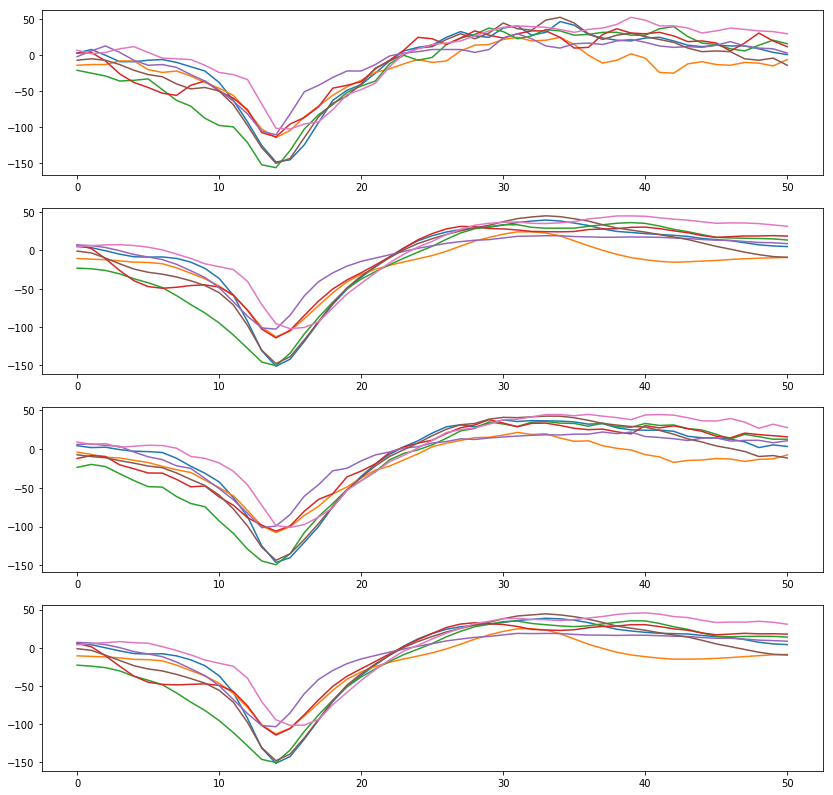

In [40]:
plt.figure(figsize=(14,14))

# n = [1, 30, 45, 50, 65]
n = [11, 290, 3490, 1098, 2707, 9, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    enc, o = ae_1.forward(data)
    o = (o.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o)))
    enc, o_gan = gen.forward(data)
    o_gan = (o_gan.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_gan)))
    enc, o_lstm = lstm_ae.forward(data)
    o_lstm = (o_lstm.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_lstm)))
    print('-----------------')
    plt.subplot(411)
    plt.plot(electrode_data_test[i, :])
    plt.subplot(412)
    plt.plot(o)
    plt.subplot(413)
    plt.plot(o_gan)
    plt.subplot(414)
    plt.plot(o_lstm)
plt.show()

## Listing all output embeddings for t-SNE

In [76]:
from sklearn import (manifold, datasets, decomposition, ensemble, 
                     discriminant_analysis, random_projection)
from sklearn.cluster import MeanShift, estimate_bandwidth

### Encoding all data points

In [42]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [73]:
encoded_data_ae = np.zeros((electrode_data.shape[0], embedding_size))
encoded_data_gan = np.zeros((electrode_data.shape[0], embedding_size))
encoded_data_lstm = np.zeros((electrode_data.shape[0], embedding_size))


for i in range(electrode_data.shape[0]):
    temp = electrode_data[i, :]
    temp = torch.from_numpy(temp).float().cuda()
    
    encoded, o = ae_1.forward(temp)
    encoded = (encoded.data).cpu().numpy()
    encoded_data_ae[i, :] = encoded[:]
    
    #print("Completed "+str(i+1)+" iterations.")

#tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
print('stage1')
#ae_pca = decomposition.TruncatedSVD(n_components=3).fit_transform(encoded_data_ae)
#ae_tsne = tsne.fit_transform(encoded_data_ae)
print('stage2')


stage1
stage2


In [82]:
ae_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(encoded_data_ae)
bandwidth = estimate_bandwidth(ae_pca, quantile=0.2, n_samples=40000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(encoded_data_ae)

labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

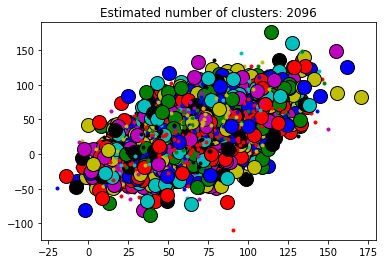

In [83]:
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(encoded_data_ae[my_members, 0], encoded_data_ae[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()